In [132]:
import numpy as np
import math
from collections import deque
from torch import nn
from src.utils.inference import *
from src.game.tweny48 import *
from src.game.dynamics import *
import matplotlib.pyplot as plt



device = "cuda" if torch.cuda.is_available() else "cpu"
device






'cpu'

In [133]:
def make_prediction(model: nn.Module ,state: np.ndarray) -> torch.tensor:
    model.eval()
    state = encode_state_batch([state])
    device = get_device()
    with torch.inference_mode():
        state = state.to(get_device())
        pred = model(state).to(device)

    return pred

In [134]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        d = out_channels // 4
        self.conv1 = nn.Conv2d(in_channels, d, 1, padding='same')
        self.conv2 = nn.Conv2d(in_channels, d, 2, padding='same')
        self.conv3 = nn.Conv2d(in_channels, d, 3, padding='same')
        self.conv4 = nn.Conv2d(in_channels, d, 4, padding='same')

    def forward(self, x):
        output1 = self.conv1(x)
        output2 = self.conv2(x)
        output3 = self.conv3(x)
        output4 = self.conv4(x)
        return torch.cat((output1, output2, output3, output4), dim=1)

class DQModelConvBlock(nn.Module):

    def __init__(self, input_neurons: int, hidden_neurons: tuple, output_neurons: int, state_size: int, dropout: float = 0.5):
        super().__init__()
        self.input_block = nn.Sequential(
            ConvBlock(in_channels= input_neurons,
                      out_channels= hidden_neurons[0]),
            nn.ReLU(),
        )


        self.hidden_blocks = nn.ModuleList()
        for i in range(1, len(hidden_neurons)):
            self.hidden_blocks.append(nn.Sequential(
               ConvBlock(in_channels= hidden_neurons[i-1],
                      out_channels= hidden_neurons[i]),
               nn.ReLU(),
            ))

        flattened_in_features = hidden_neurons[-1]*(state_size**2)
        flatten_out_features = hidden_neurons[-1] //2
        self.output_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_in_features,
                      out_features=flatten_out_features),
            nn.Dropout(dropout),
            nn.Linear(in_features=flatten_out_features,
                      out_features=output_neurons)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_block(x)
        for hidden_block in self.hidden_blocks:
            x = hidden_block(x)
        return self.output_block(x)

In [135]:
class DQModel(nn.Module):

    def __init__(self, input_neurons: int, hidden_neurons: tuple, output_neurons: int, state_size: int, dropout: float = 0.5):
        super().__init__()
        self.input_block = nn.Sequential(
            nn.Conv2d(in_channels= input_neurons,
                      out_channels= hidden_neurons[0],
                      kernel_size=3,
                      padding="same"),
            nn.BatchNorm2d(hidden_neurons[0]),
            nn.ReLU(),
        )


        self.hidden_blocks = nn.ModuleList()
        for i in range(1, len(hidden_neurons)):
            self.hidden_blocks.append(nn.Sequential(
               nn.Conv2d(in_channels= hidden_neurons[i-1],
                      out_channels= hidden_neurons[i],
                      kernel_size=2,
                      padding="same"),
               nn.BatchNorm2d(hidden_neurons[i]),
               nn.ReLU(),
            ))

        flattened_in_features = hidden_neurons[-1]*(state_size**2)
        flatten_out_features = flattened_in_features // 2
        self.output_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_in_features,
                      out_features=flatten_out_features),
            nn.BatchNorm1d(flatten_out_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=flatten_out_features,
                      out_features=output_neurons)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_block(x)
        for hidden_block in self.hidden_blocks:
            x = hidden_block(x)
        return self.output_block(x)


In [136]:
class ReplayBuffer(deque):

    def __init__(self, capacity: int = 6000):
        super().__init__(maxlen=capacity)
        self.capacity: int = capacity

    def append(self, transition):
        super().append(transition)

    def full(self) -> bool:
        return len(self) >= self.maxlen

    def sample(self, batch_size: int):
        return random.sample(self, batch_size)



In [137]:
def encode_state_batch(states: list[np.ndarray]):

    states_flat = []
    for state in states:
        state_log = np.where(state == 0, 0, np.log2(state)).astype(np.int64)
        states_flat.append(state_log)

    states_tensor = torch.Tensor(np.array(states_flat)).long().to(get_device())

    states_one_hot = torch.nn.functional.one_hot(states_tensor, num_classes=12).float().to(get_device())

    states_one_hot = states_one_hot.permute(0, 3, 1, 2)

    return states_one_hot

In [138]:
def get_reward1(current_state, next_state, actions, win_val):
    reward = 0
    result = check_terminal(next_state, actions, win_val)
    if result =="W":
        reward += 10
    elif result == "L":
        reward -= 10
    elif np.array_equal(current_state, next_state):
        reward -= 5

    return reward

In [139]:
class DQL(Twenty48):

    def __init__(self, win_val = 256, max_epsilon: float = 0.9, min_epsilon:float = 0.01, alpha: float = 0.00005):
        super().__init__()
        self.main_network: DQModelConvBlock = self.create_network().to(get_device())
        self.target_network: DQModelConvBlock = self.create_network().to(get_device())
        self.replay_buffer: ReplayBuffer = ReplayBuffer(6000)

        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.win_val = win_val
        self.epsilon = max_epsilon

        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.main_network.parameters(), lr=alpha)

    def train(self, episodes, batch_size: int= 32):
        results = []
        total_scores = []
        steps = 0
        total_loss = 0

        for episode in range(1, episodes):
            while (result := check_terminal(self.environment, self.ACTIONS, self.win_val)) == "":
                self.interact()
                steps += 1
            self.decay_epsilon(episode, episodes)

            results.append(result)
            if len(self.replay_buffer) > batch_size:
                for _ in range(100):
                    total_loss += self.update_main_network(self.loss_fn, self.optimizer, batch_size)

            if episode % 20 == 0:
                self.update_target_network()

            if episode % 10 == 0:
                win_rate = sum([1 for r in results if r == "W"]) / 10
                print(f"Episode: {episode} | Result: {win_rate} | Highest_Val: {np.max(self.environment)}| avg_steps: {steps/episode} | epsilon: {self.epsilon} | loss: {total_loss/(100*10)}")
                results = []
                total_loss = 0

            total_scores.append(self.total)
            if episode > 50:
                average = sum(total_scores[-50:]) / 50
                print(f"50 episode running average: {average}")
            self.reset()
            self.total = 0


    def interact(self):
        current_state = self.copy()
        action = self.get_action()
        moved, merge_values = game_step(self.environment, action)
        reward = get_reward1(current_state, self.environment,self.ACTIONS, self.win_val)
        next_state = self.copy()
        done = 1 if check_terminal(self.environment, self.ACTIONS) != "" else 0

        self.total += sum(merge_values)

        if check_terminal(self.environment, self.ACTIONS, self.win_val) != "" or len(self.replay_buffer) == 0 or (moved or merge_values):
            self.replay_buffer.append((current_state, action, reward, next_state, done))

    def decay_epsilon(self, episode, max_episodes, power: float= 1.2):
        fraction = episode/max_episodes
        self.epsilon = (self.max_epsilon - self.min_epsilon) * ((1 - fraction) ** power) + self.min_epsilon

    def decay_epsilon1(self, episode, max_episodes, decay = 0.9999):
        self.epsilon = max(self.min_epsilon, self.max_epsilon * (decay ** episode))

    def update_target_network(self):
        self.target_network.load_state_dict(self.main_network.state_dict())

    def update_main_network(self, loss_fn, optimizer, batch_size: int, gamma: float= 0.9):
        device = get_device()

        batch = list(self.replay_buffer.sample(batch_size))
        states = encode_state_batch([transition[0] for transition in batch]).to(get_device())
        actions = [transition[1] for transition in batch]
        rewards = torch.Tensor([transition[2] for transition in batch]).to(get_device())
        next_states = encode_state_batch([transition[3] for transition in batch]).to(get_device())
        dones = torch.Tensor([transition[4] for transition in batch]).to(get_device())

        self.main_network.train()
        self.target_network.eval()

        main_y = self.main_network(states).to(device)

        with torch.inference_mode():
            target_y = self.target_network(next_states).to(device)

        action_indices = [self.ACTIONS.index(action) for action in actions]
        current_q_values = main_y[range(len(actions)), action_indices]

        max_next_q_values = torch.amax(target_y, dim=1)

        target_q_values = rewards + ((1 - dones) * (gamma * max_next_q_values))

        loss_fn = nn.MSELoss()
        loss = loss_fn(current_q_values, target_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def get_action(self) -> str:
        if random.random() >= self.epsilon:
            return self.get_best_action()
        else:
            return self.get_random_action()

    def get_random_action(self) -> str:
        invalid_actions = get_invalid_actions(self.environment, self.ACTIONS)
        valid_actions = [action for action in self.ACTIONS if action not in invalid_actions]
        return random.choice(self.ACTIONS)

    def get_best_action(self) -> str:
        invalid_actions  = get_invalid_actions(self.environment, self.ACTIONS)
        invalid_indices = [i for i, action in enumerate(self.ACTIONS) if action in invalid_actions]

        prediction = make_prediction(self.main_network, self.environment).squeeze()
        masked_q_values = prediction.clone()
        masked_q_values[invalid_indices] = -float('inf')
        return self.ACTIONS[torch.argmax(prediction).item()]

    def create_network(self, hidden_neurons: tuple = (64, 64, 64, 64), ):
        return DQModelConvBlock(input_neurons=12,
                       hidden_neurons=hidden_neurons,
                       output_neurons=len(self.ACTIONS),
                       state_size=len(self))

    def update_target_network_advanced(self, tau: float = 0.001):
        for target_param, main_param in zip(self.target_network.parameters(), self.main_network.parameters()):
            target_param.data.copy_(
                tau * main_param.data + (1.0 - tau) * target_param.data
            )









In [140]:
dql = DQL()
dql.train(200)

/var/folders/v8/_7nzg4ln01d8js37_knftkp40000gp/T/ipykernel_25904/1248462863.py:5: RuntimeWarning: divide by zero encountered in log2
  state_log = np.where(state == 0, 0, np.log2(state)).astype(np.int64)


KeyboardInterrupt: 

In [141]:
def trail_random_ai(ai, episodes: int) -> dict:
    wins = 0
    dic = {}
    print("sum")
    for i in range(1, episodes):
        while (result := check_terminal(ai.environment, ai.ACTIONS, ai.win_val)) == "":
            action = ai.get_random_action()
            moved, merge = game_step(ai.environment, action)
            if not moved and not merge:
                action = ai.get_random_action()
                moved, merge = game_step(ai.environment, action)

        max_val = np.max(ai.environment)
        ai.reset()
        wins += 1 if result == "W" else 0
        if i % (episodes / 10) == 0:
            print(i)
        dic[max_val] = dic.get(max_val, 0) + 1
    return dic

In [142]:
def plot_graph(results:dict):
    tile_values = [float(x) for x in results.keys()]
    occurrences = list(results.values())
    # Sort data for better visualization
    sorted_data = sorted(zip(tile_values, occurrences), key=lambda x: x[0])
    sorted_tiles, sorted_occurrences = zip(*sorted_data)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.bar(sorted_tiles, sorted_occurrences, color='skyblue', edgecolor='black')
    plt.xlabel("Tile Value", fontsize=12)
    plt.ylabel("Occurrences", fontsize=12)
    plt.title("Tile Occurrences in 2048", fontsize=14)
    plt.xticks(sorted_tiles)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

sum
100
200
300
400
500
600
700
800
900


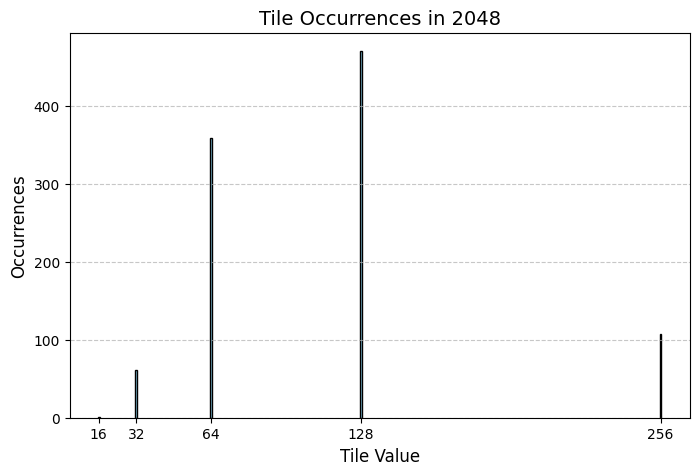

In [144]:
plot_graph(trail_random_ai(DQL(), 1000))